In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType, ArrayType

In [2]:
#sc._conf.getAll()

In [3]:
config = SparkConf().setAll([
    ('spark.executor.cores', '2'), ('spark.executor.memory', '4g'), ('spark.driver.memory','4g'), ('spark.submit.deployMode','client')
])
sc.stop()
sc = SparkContext(conf=config)

#sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [4]:
#df = sqlContext.read.csv('gs://kaggle01_test/notebooks/jupyter/pyspark-ecommerce-prediction-main/ecommerce-data100.csv', header=True)
df = sqlContext.read.csv('ecommerce-data.csv', header=True)

#df = df.drop_duplicates(['CustomerID'])
df = df.na.drop()
df = df.withColumn("CustomerID", df["CustomerID"].cast('int'))
df = df.withColumn("Quantity", df["Quantity"].cast('int'))
df = df.withColumn("UnitPrice", df["UnitPrice"].cast('float'))

df = df.withColumn("Date", to_date(col("InvoiceDate"),"MM/dd/yyyy"))

df = df.filter((df['Quantity'] > 0) & (df['UnitPrice'] > 0))

df = df.withColumn('TotalPrice', df['Quantity'] * df['UnitPrice'])
# & (df['UnitPrice'] < 15)
#df = df.filter(df['TotalPrice'] < 25000)

df.count()

#df.show()
#df.show(df.count())

397884

In [5]:
import datetime as dt
now = to_date(lit(dt.date(2011,12,9)))

recency_df = df.groupby('CustomerID').agg(max('Date').alias('LastPurchaseDate'))
recency_df = recency_df.withColumn("Diff", datediff(now, to_date(recency_df['LastPurchaseDate'])))
recency_df = recency_df.groupby('CustomerID').agg(min('Diff').alias('Recency'))
#recency_df.show()

#frequency_df = df.drop_duplicates(['CustomerID', 'InvoiceNo'])
frequency_df = df.groupby('CustomerID').agg(count('InvoiceNo').alias('Frequency'))
#frequency_df.show()

monetary_df = df.groupby('CustomerID').agg(sum('TotalPrice').alias('Monetary'))
#monetary_df.show()

rfm = recency_df.join(frequency_df, on=['CustomerID'], how='inner')
rfm = rfm.join(monetary_df, on=['CustomerID'], how='inner')
#rfm.show()

In [6]:
def get_outliers(rfm, column):
    quantiles = rfm.stat.approxQuantile(column, [0.05, 0.95], 0.0)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lowerRange = Q1 - 1.5 * IQR
    upperRange = Q3 + 1.5 * IQR
    rfm.filter((rfm[column] < lowerRange) | (rfm[column] > upperRange)).show()

def remove_outliers(rfm, column):
    quantiles = rfm.stat.approxQuantile(column, [0.05, 0.95], 0.0)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1
    lowerRange = Q1 - 1.5 * IQR
    upperRange = Q3 + 1.5 * IQR
    rfm = rfm.filter((rfm[column] >= lowerRange) | (rfm[column] <= upperRange))

#get_outliers(rfm, 'Recency')
#get_outliers(rfm, 'Frequency')
#get_outliers(rfm, 'Monetary')
remove_outliers(rfm, 'Recency')
remove_outliers(rfm, 'Frequency')
remove_outliers(rfm, 'Monetary')

In [7]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['Recency', 'Frequency', 'Monetary'],
    outputCol="features")

rfm_feat = rfm.withColumnRenamed('CustomerID', 'id')

rfm_feat = assembler.transform(rfm_feat).select('id', 'features')
#rfm_feat.show()

In [8]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")#, withStd=True, withMean=False
scalerModel = scaler.fit(rfm_feat)

rfm_final = scalerModel.transform(rfm_feat).select('id', 'scaledFeatures')
rfm_final = rfm_final.withColumnRenamed('scaledFeatures', 'features')
#rfm_final.show()

In [9]:
def size_of_partition(map_of_rows):
    list_of_rows = list(map_of_rows)
    size_of_list = len(list_of_rows)
    return [size_of_list]

#df.rdd.mapPartitions(size_of_partition).collect()
#rfm_final.rdd.getNumPartitions()

In [10]:
#reparted_rdd = df.rdd.repartition(20)

In [11]:
#reparted_rdd.mapPartitions(size_of_partition).collect()

In [12]:
#reparted_rdd.map(lambda x: x).toDF().show(reparted_rdd.count())

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_clusters = 10
cost = np.zeros(n_clusters)
silh_val = []
silh_lst = []

for k in range(2, n_clusters):
    kmeans = KMeans().setK(k).setSeed(1).setMaxIter(50).setFeaturesCol("features")
    model = kmeans.fit(rfm_final)# rfm_final.sample(False,0.1, seed=42)
    
    # elbow method
    cost[k] = model.summary.trainingCost
        
    predictions = model.transform(rfm_final)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silh_val.append(silhouette)


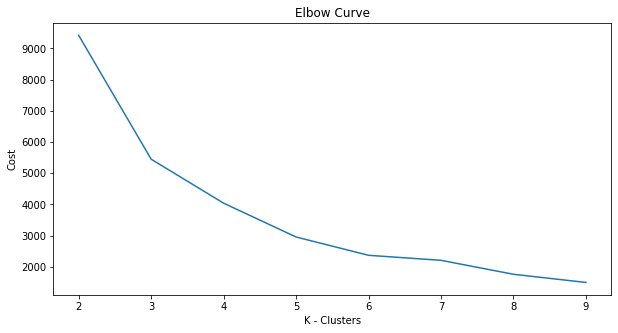

In [ ]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sbs
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(10,5))
ax.plot(range(2, n_clusters),cost[2:n_clusters])
plt.xlabel('K - Clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [ ]:
silh_array = np.asanyarray(silh_val)
silhouette = pd.DataFrame(list(zip(range(2, n_clusters),silh_array)),columns = ['K - Clusters', 'silhouette'])
silhouette

,K - Clusters,silhouette
0,2,0.466284
1,3,0.742901
2,4,0.740786
3,5,0.772852
4,6,0.760554
5,7,0.758797
6,8,0.695908
7,9,0.656742


In [ ]:
from pyspark.ml.clustering import KMeans

k = 3
kmeans = KMeans().setK(k).setSeed(1).setMaxIter(50).setFeaturesCol("features")
model = kmeans.fit(rfm_final)
predictions = model.transform(rfm_final)
predictions = predictions.withColumnRenamed('id', 'CustomerID')
predictions = predictions.withColumnRenamed('prediction', 'Cluster')
predictions = predictions.select(['CustomerID', 'Cluster'])
#print(model.computeCost(rfm_final), model.summary.trainingCost)

In [ ]:
model.summary.clusterSizes

[3245, 1080, 13]

In [ ]:
model.clusterCenters()

[array([0.40901917, 0.45065   , 0.22572632]),
 array([2.46783623, 0.12128882, 0.07080707]),
 array([ 0.03999509, 11.21273965, 14.02993403])]

In [23]:
df_cluster = df.join(predictions, on=['CustomerID'], how='inner')
#df_cluster.show(df_cluster.count())
df_cluster.show()

+----------+---------+---------+--------------------+--------+----------------+---------+--------------+----------+----------+-------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|     InvoiceDate|UnitPrice|       Country|      Date|TotalPrice|Cluster|
+----------+---------+---------+--------------------+--------+----------------+---------+--------------+----------+----------+-------+
|     12940|   566488|    22191|IVORY DINER WALL ...|       2| 9/13/2011 10:16|      8.5|United Kingdom|2011-09-13|      17.0|      0|
|     12940|   566488|    22423|REGENCY CAKESTAND...|       4| 9/13/2011 10:16|    12.75|United Kingdom|2011-09-13|      51.0|      0|
|     12940|   566488|    23173|REGENCY TEAPOT RO...|       2| 9/13/2011 10:16|     9.95|United Kingdom|2011-09-13|      19.9|      0|
|     12940|   566488|    23174|REGENCY SUGAR BOW...|       4| 9/13/2011 10:16|     4.15|United Kingdom|2011-09-13|      16.6|      0|
|     12940|   566488|    23175|REGENCY MILK JUG ...|  

In [25]:
df_cluster.write.csv('user_ecommerce-data.csv', header=True)

In [ ]:
#predictions.write.csv('customer_segmentation.csv', header=True)

In [ ]:
#output = sqlContext.read.csv('customer_segmentation.csv', header=True)
#output.show(output.count())